In [141]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt 

In [142]:
# File Path
shawn_1 = 'algo_shawn_pc1/algo2_data_shawn_pc1.xlsx'
shawn_2 = 'algo_shawn_pc2/algo2_data_shawn_pc2.xlsx'
shawn_3 = 'algo_shawn_pc3/algo2_data_shawn_pc3.xlsx'
david_1 = 'algo_david_pc1/algo2_data_david_pc1.xlsx'
david_2 = 'algo_david_pc2/algo2_data_david_pc2.xlsx'

file_path_lst = [shawn_1, shawn_2, shawn_3, david_1, david_2]

# Load Data
df_lst = []
for file in file_path_lst:
    df = pd.read_excel(file)
    df['session_end_time_num'] = df['session_end_time'].str.replace("-","").str.replace(":","").str.replace(" ","").astype('int64')
    df_lst.append(df)

df_concat = pd.concat(df_lst)
df_concat.head()

,session_end_time,algo_version,run_by,total_pl,cnr_pl,ry_pl,ac_pl,total_vol,cnr_vol,ry_vol,ac_vol,total_active_traders,cnr_active_traders,ry_active_traders,ac_active_traders,total_orders_per_trader,cnr_orders_per_trader,ry_orders_per_trader,ac_orders_per_trader,session_end_time_num
0,2022-04-01 22:39,Team12_ALGO2_2_Strat1_v1.0,Shawn-PC1,106594.26,0.0,106594.26,0.0,21760000,0,21760000,0,2,1,2,1,"{'1003010555': 6130, '1002577892': 2972}",{'1003010555': 1676},"{'1003010555': 3726, '1002577892': 2972}",{'1003010555': 728},202204012239
1,2022-04-01 22:45,Team12_ALGO2_2_Strat1_v1.0,Shawn-PC1,330972.42,0.0,330972.42,0.0,21580000,0,21580000,0,2,1,2,1,"{'1003010555': 6466, '1002577892': 3229}",{'1003010555': 1588},"{'1003010555': 4073, '1002577892': 3229}",{'1003010555': 805},202204012245
2,2022-04-01 22:57,Team12_ALGO2_2_Strat1_v1.0,Shawn-PC1,33627.06,0.0,33627.06,0.0,20890000,0,20890000,0,4,2,3,2,"{'1002935531': 8834, '1003010555': 6002, '1002...","{'1002935531': 4011, '1003010555': 1750}","{'1003010555': 3651, '1002577892': 2469, '1002...","{'1002935531': 4823, '1003010555': 601}",202204012257
3,2022-04-01 23:03,Team12_ALGO2_2_Strat1_v1.0,Shawn-PC1,26722.48,0.0,26722.48,0.0,18405000,0,18405000,0,4,2,3,2,"{'1002935531': 8665, '1003010555': 5736, '1002...","{'1002935531': 4358, '1003010555': 1461}","{'1003010555': 3692, '1002174942': 3280, '1002...","{'1002935531': 4307, '1003010555': 583}",202204012303
4,2022-04-01 23:09,Team12_ALGO2_2_Strat1_v1.0,Shawn-PC1,75096.68,0.0,75096.68,0.0,17925000,0,17925000,0,4,2,3,2,"{'1002935531': 8717, '1003010555': 5703, '1002...","{'1002935531': 3939, '1003010555': 1403}","{'1002174942': 3971, '1003010555': 3414, '1002...","{'1002935531': 4778, '1003010555': 886}",202204012309


In [143]:
min_algos = 1
latest = 30


version_to_ignore = ['Team12_ALGO2_2_Strat1_v1.0',
                    'Team12_ALGO2_2_Strat1_v1.1',
                    'Team12_ALGO2_2_Strat1_v2.0',
                    'Team4_ALGO2_2_Strat1_v5_byShawnPC1']

version_to_consider = ['Team12_ALGO2_2_Strat1_v3.2', 'Team12_ALGO2_2_Strat1_v4.1']

# Sorted Timeseries
time_series = df_concat['session_end_time_num'].drop_duplicates().sort_values()[-latest:]

# Define functions
def get_dataframe(variable, sec_var, by_vars=['algo_version', 'run_by'], new_df_temp=pd.DataFrame(data = time_series), 
                  master_df=df_concat, index_var='session_end_time_num', min_algos=min_algos):
    return_lst = []
    for by_var in by_vars:
        no_dup_list = master_df[by_var].drop_duplicates().tolist()
        by_lst = list(set(no_dup_list) - set(version_to_ignore)) if by_var == 'algo_version' else no_dup_list
        if by_var == 'algo_version' and (version_to_consider is not None):
            by_lst = version_to_consider
        new_df = new_df_temp
        for item in by_lst:
            cond = master_df[by_var] == item
            df_tojoin = master_df.loc[cond][[index_var, variable]]
            df_tojoin.columns = [index_var, item]
            new_df = new_df.merge(df_tojoin, how='left')
        
        sec_var_df = master_df[[index_var, sec_var]].drop_duplicates()
        new_df = new_df.merge(sec_var_df, how='left', on=index_var)
        new_df.dropna(thresh=min_algos+2, inplace=True)
        return_lst.append(new_df)
        
    return return_lst


def print_plot(var, plot_kind='line', plot_size=(20, 10), sec_var='total_active_traders', latest=latest):
    dataframes = get_dataframe(var, sec_var=sec_var)
    for df in dataframes:
        df.reset_index(inplace=True,drop=True)
        df.iloc[:,1:-1].plot(kind=plot_kind, figsize=plot_size)
        ax = df[sec_var].plot(secondary_y=True, kind='bar', alpha=0.2)
        ax.set_ylabel(sec_var)
        ax.set_ylim(0,df[sec_var].max() * 2)

## PnL Analysis

### Total PnL

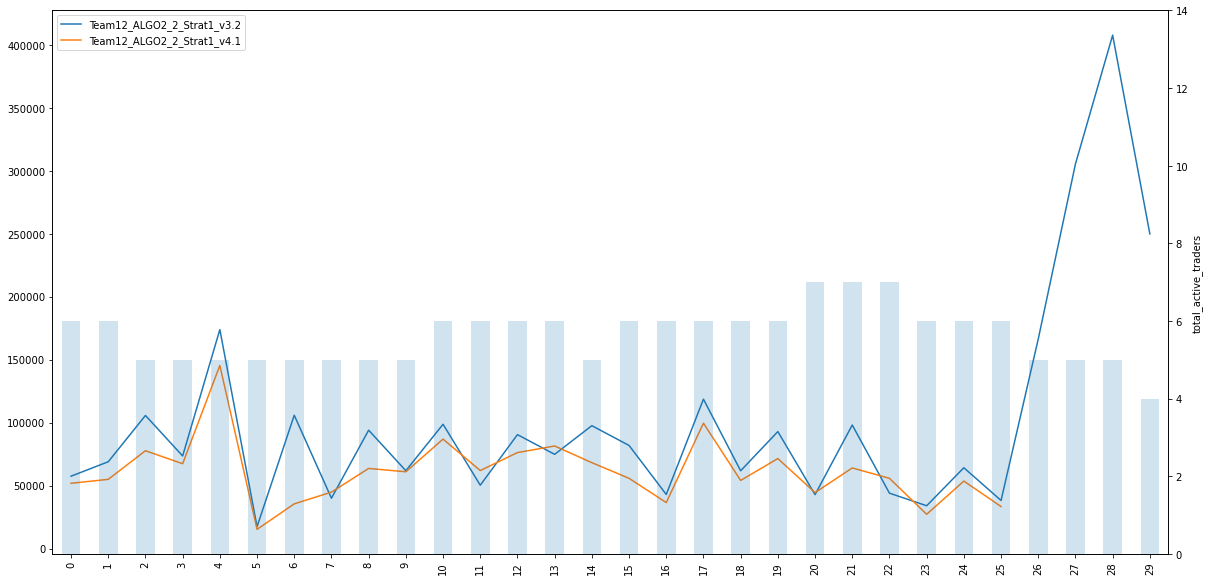

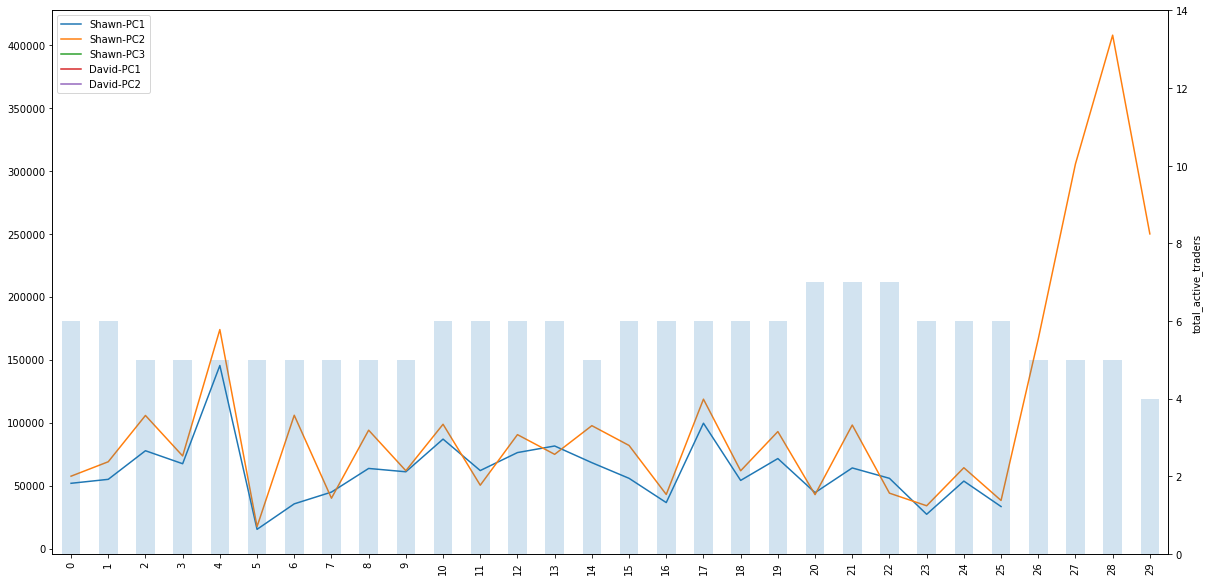

In [144]:
print_plot('total_pl')

### CNR PnL

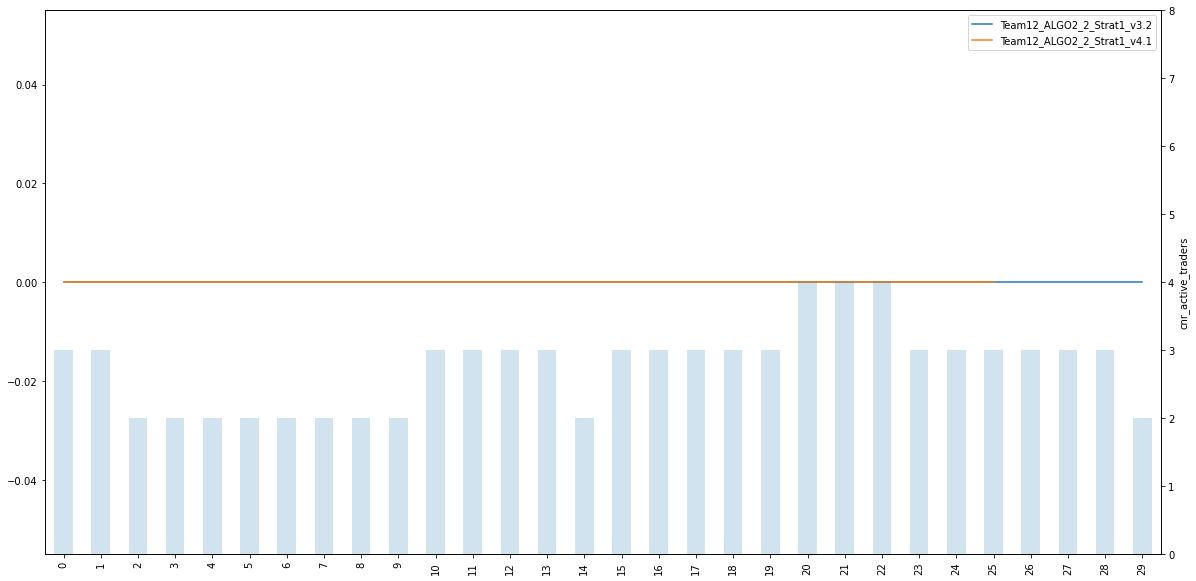

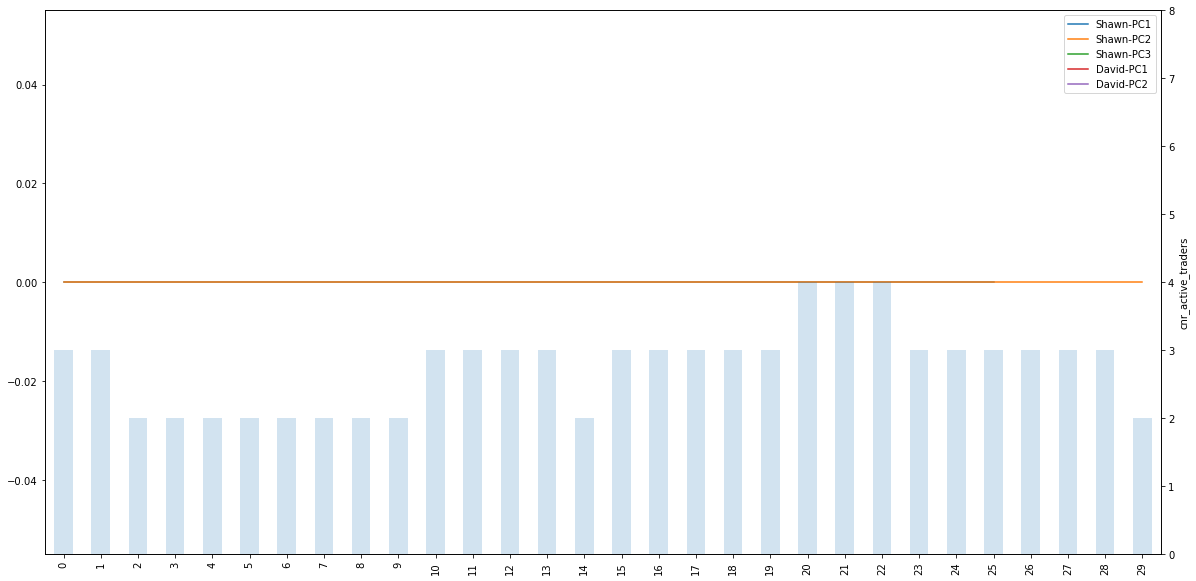

In [145]:
print_plot('cnr_pl', sec_var='cnr_active_traders')

### RY PnL

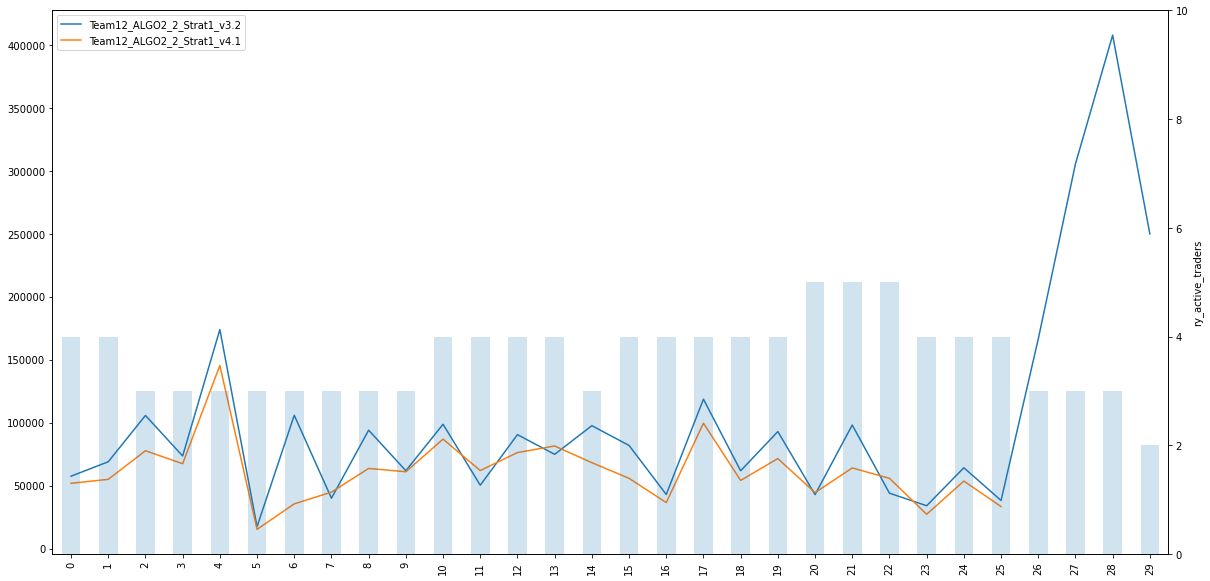

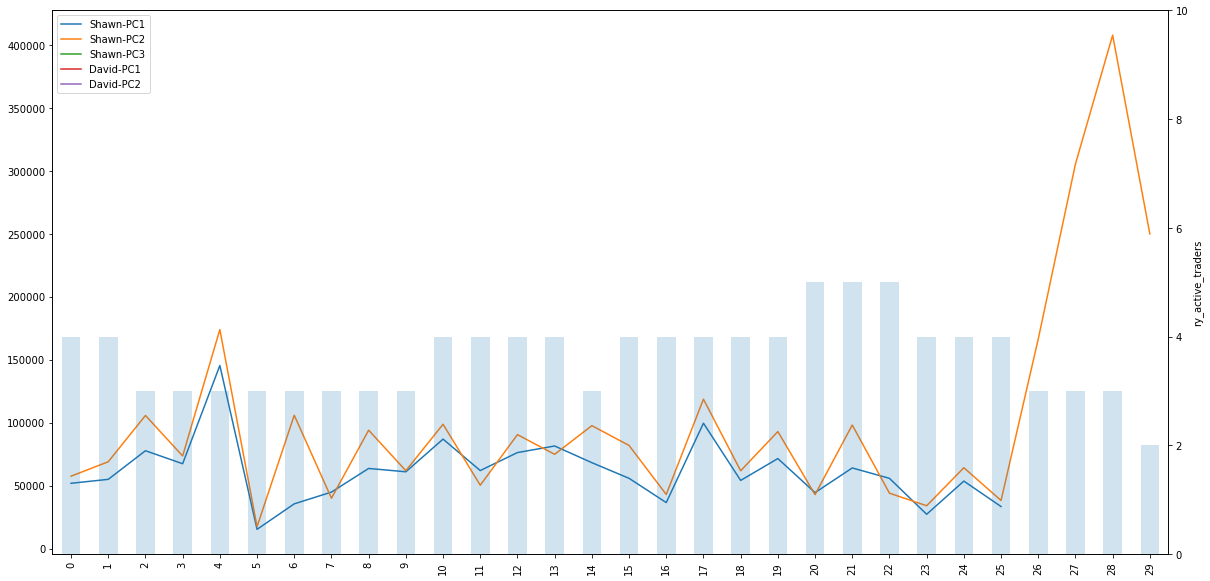

In [146]:
print_plot('ry_pl', sec_var='ry_active_traders')

### AC PnL

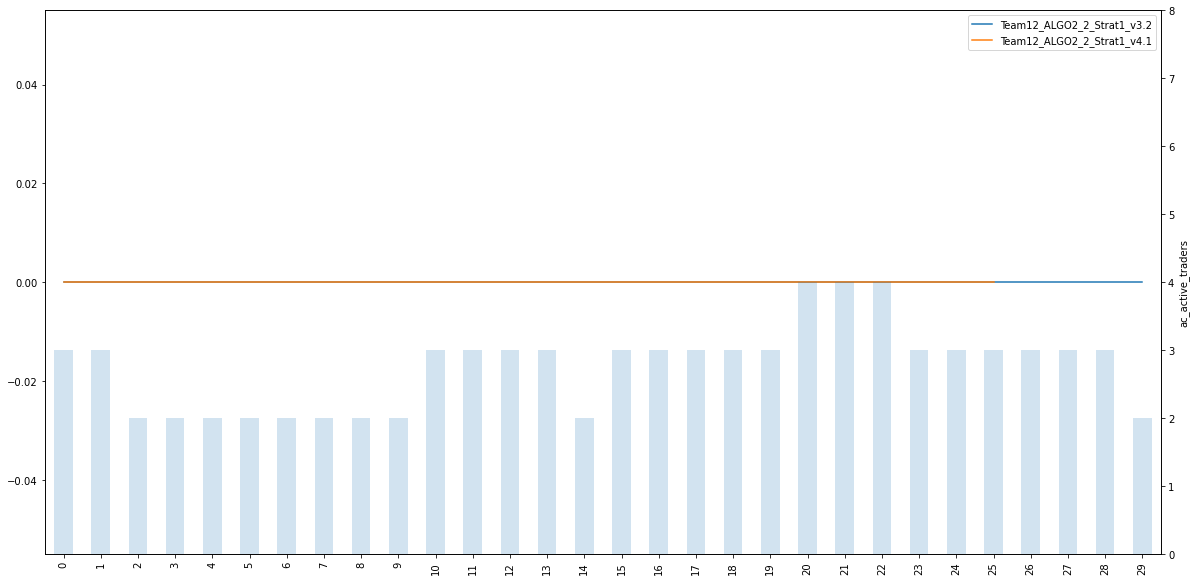

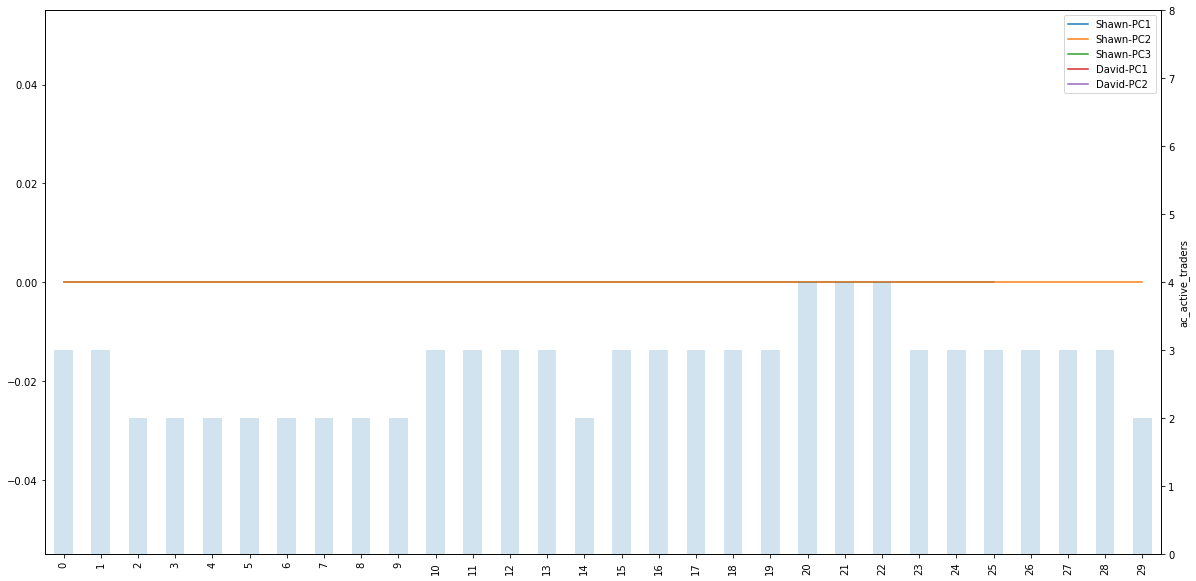

In [147]:
print_plot('ac_pl', sec_var='ac_active_traders')

## Volume Analysis

### Total Vol

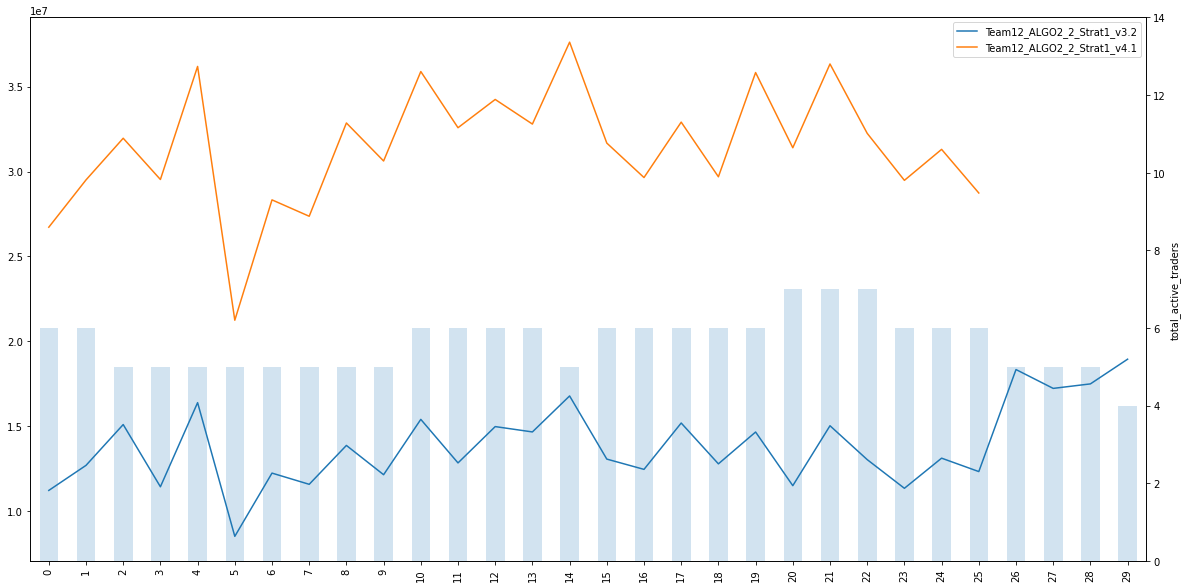

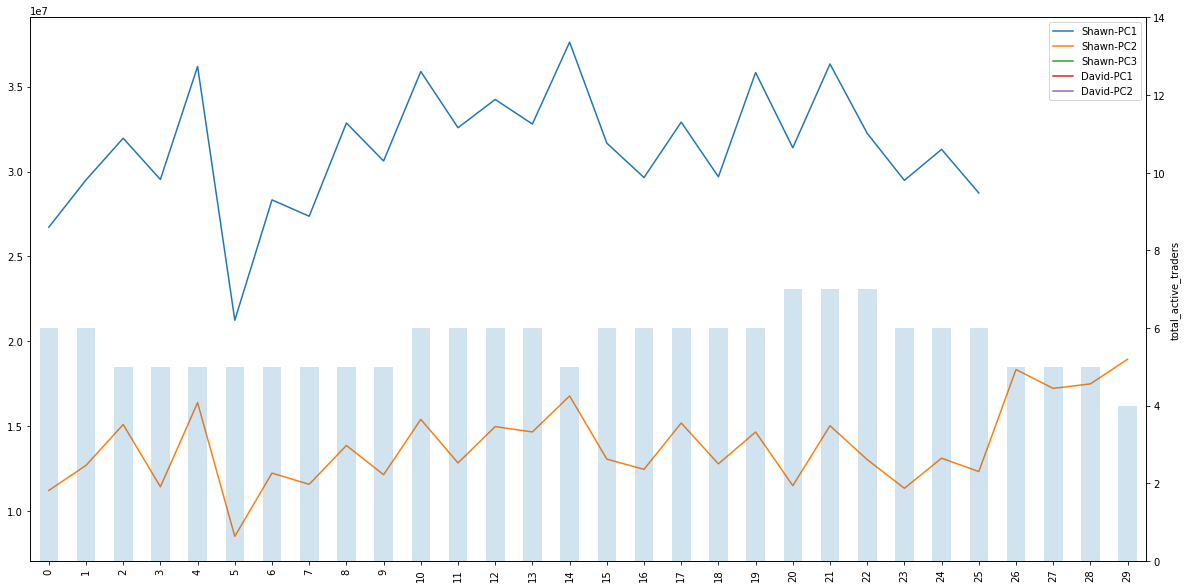

In [148]:
print_plot('total_vol')

### CNR Vol

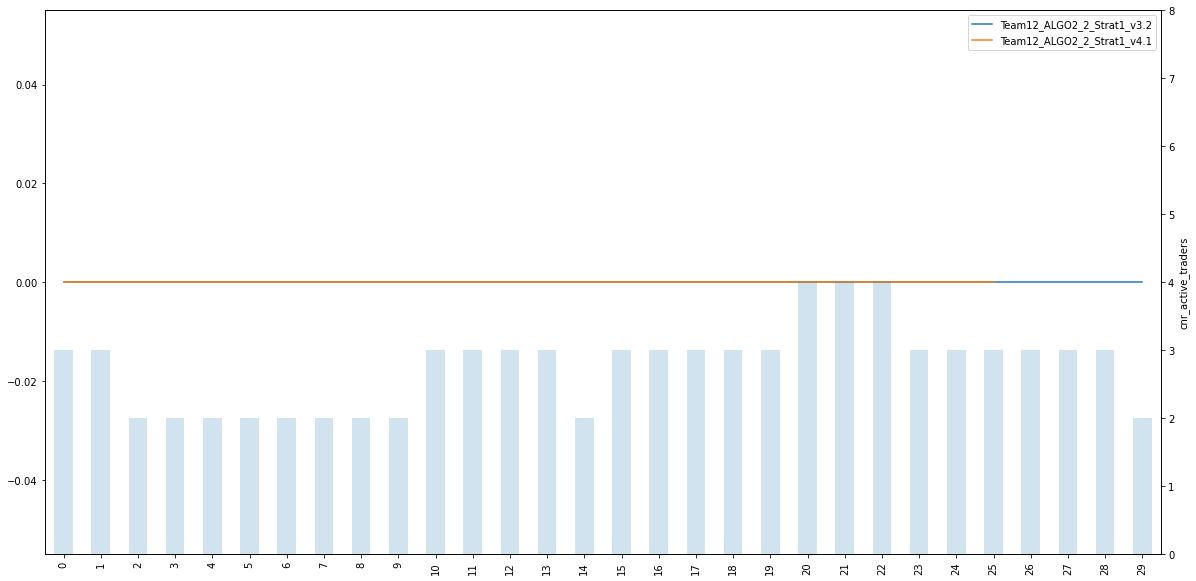

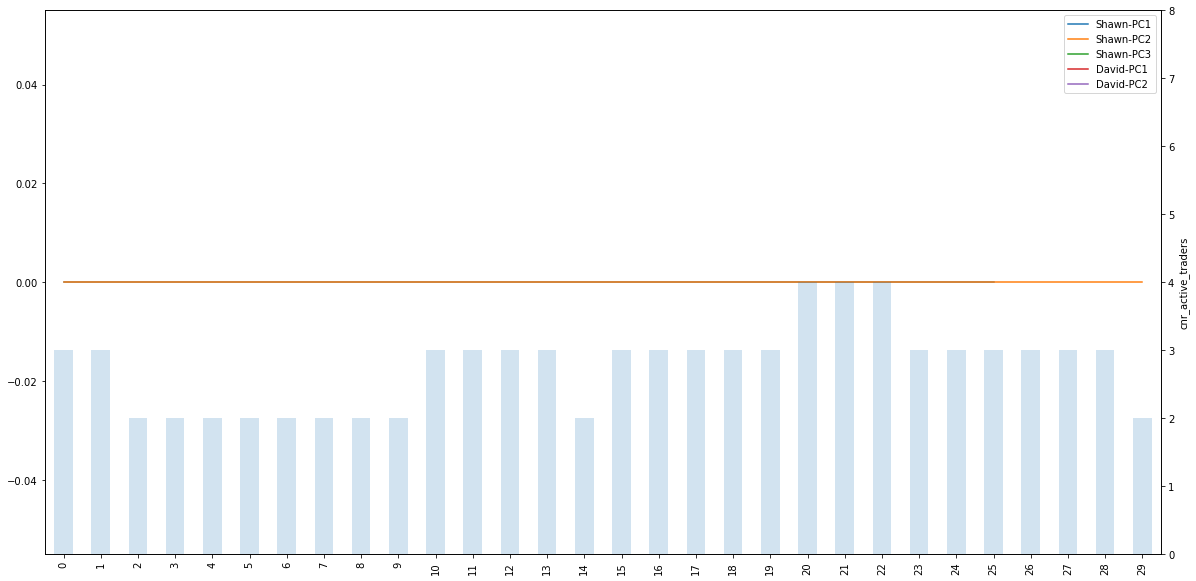

In [149]:
print_plot('cnr_vol', sec_var='cnr_active_traders')

### RY Vol

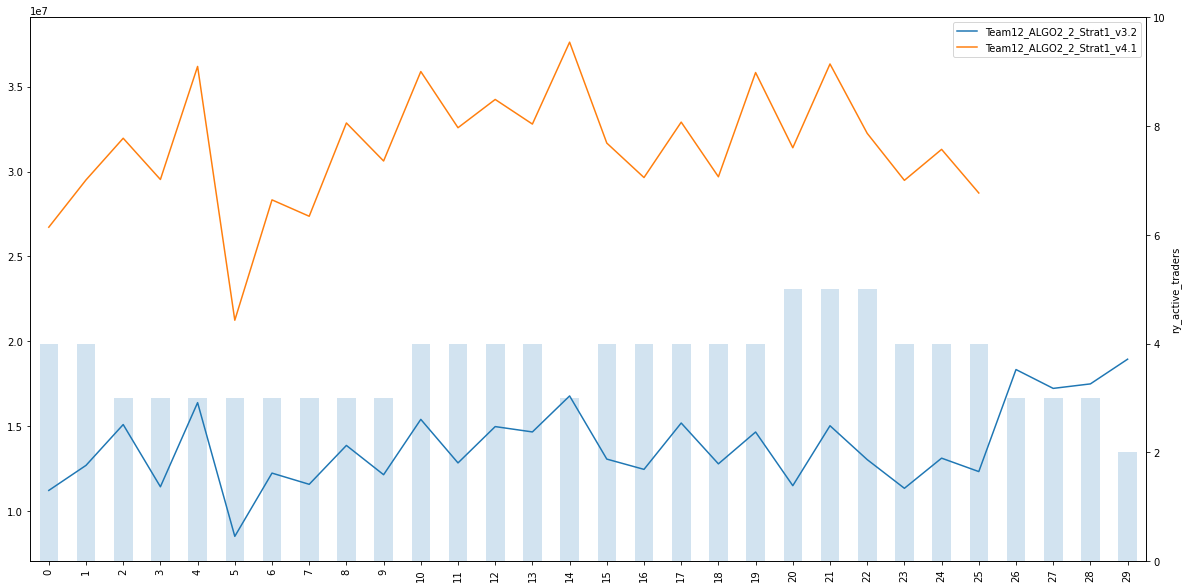

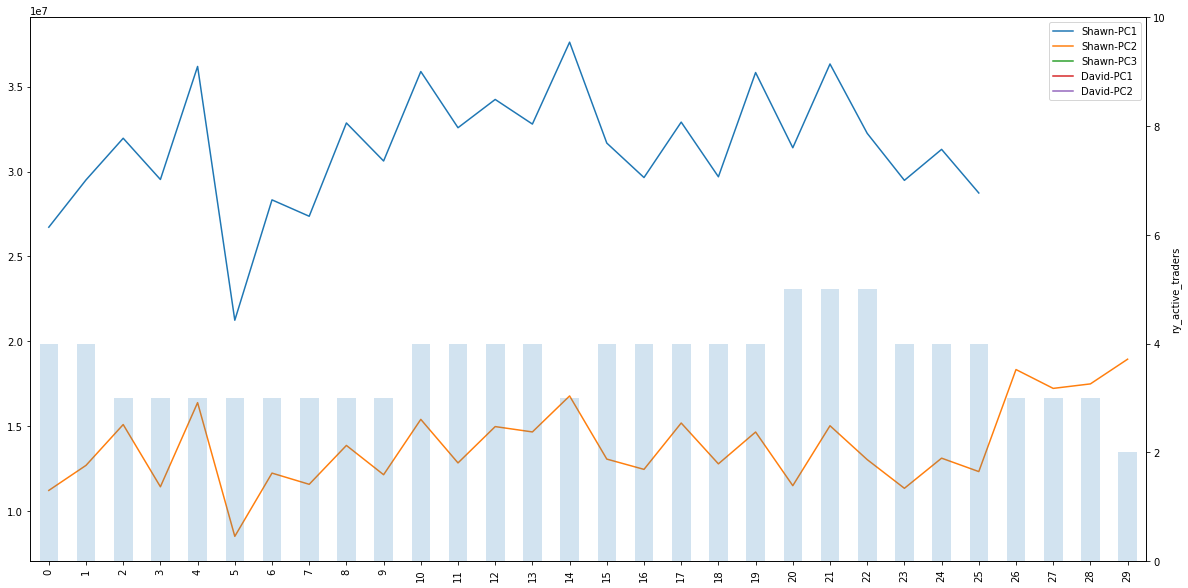

In [150]:
print_plot('ry_vol', sec_var='ry_active_traders')

### AC Vol

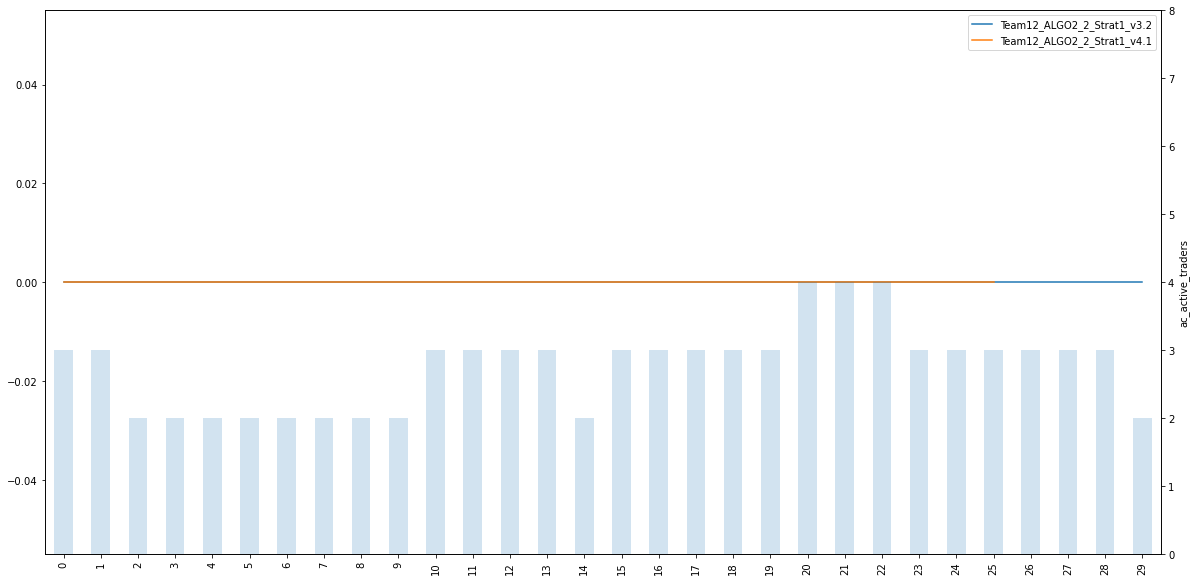

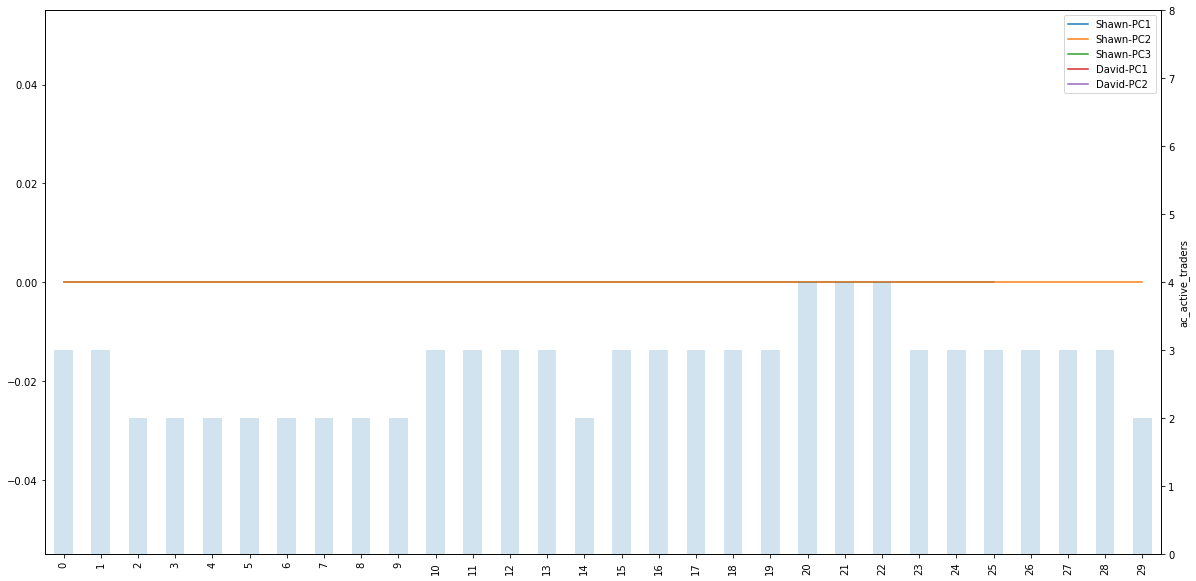

In [151]:
print_plot('ac_vol', sec_var='ac_active_traders')